In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import shutil
import os

# Path to your input image (change folder name accordingly)
src_path = "/kaggle/input/images1/AppleHarvest-UHD.jpg"

# Destination path inside working directory
dst_path = "/kaggle/working/image.jpg"

# Copy the file
shutil.copy(src_path, dst_path)

print("Image copied to working directory:", dst_path)


In [ ]:
!pip install cupy-cuda12x


In [ ]:
import cv2
import cupy as cp
import matplotlib.pyplot as plt

# -----------------------------
# 1. READ IMAGE (GRAY)
# -----------------------------
img = cv2.imread("/kaggle/input/images1/AppleHarvest-UHD.jpg", cv2.IMREAD_GRAYSCALE)
rows, cols = img.shape
plt.figure(figsize=(5,5))
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis("off")

# Convert image → GPU array
img_gpu = cp.asarray(img.flatten())

# -----------------------------
# 2. IMAGE → BITSTREAM (GPU)
# -----------------------------
bits = cp.unpackbits(img_gpu)    # GPU bit unpacking

# -----------------------------
# 3. QPSK MAPPING (GPU)
# -----------------------------
bit_pairs = bits.reshape((-1, 2))

# Mapping table (convert to CuPy)
mapping_table = {
    (0,0): (1+1j)/cp.sqrt(2),
    (0,1): (-1+1j)/cp.sqrt(2),
    (1,0): (1-1j)/cp.sqrt(2),
    (1,1): (-1-1j)/cp.sqrt(2)
}

# Vectorized GPU mapping
symbols = cp.array([mapping_table[(int(b[0]), int(b[1]))] for b in bit_pairs])

# -----------------------------
# 4. ADD AWGN NOISE (GPU)
# -----------------------------
EbN0_dB = 10

EbN0 = 10**(EbN0_dB/10)
Es = cp.mean(cp.abs(symbols)**2)
N0 = Es / EbN0

noise = cp.sqrt(N0/2) * (cp.random.randn(len(symbols)) + 1j * cp.random.randn(len(symbols)))

rx_symbols = symbols + noise

# -----------------------------
# 5. QPSK DEMODULATION (GPU)
# -----------------------------
constellation = cp.array(list(mapping_table.values()))
bit_lookup = cp.array(list(mapping_table.keys()))

rx_bits = []

for r in rx_symbols:
    distances = cp.abs(r - constellation)
    idx = int(cp.argmin(distances))
    rx_bits.extend(bit_lookup[idx])

rx_bits = cp.array(rx_bits, dtype=cp.uint8)

# -----------------------------
# 6. BITSTREAM → IMAGE (GPU → CPU)
# -----------------------------
rx_bytes = cp.packbits(rx_bits).get()   # bring to CPU
rx_img = rx_bytes.reshape(rows, cols)

# -----------------------------
# 7. SHOW RESULT
# -----------------------------
plt.figure(figsize=(5,5))
plt.imshow(rx_img, cmap='gray')
plt.title(f"Received Image (GPU, Eb/N0 = {EbN0_dB} dB)")
plt.axis("off")
plt.show()


In [ ]:
import cv2
import cupy as cp
import matplotlib.pyplot as plt

# -----------------------------
# 1. READ IMAGE (CPU → GPU)
# -----------------------------
img = cv2.imread("/kaggle/input/images1/AppleHarvest-UHD.jpg",
                 cv2.IMREAD_GRAYSCALE)

rows, cols = img.shape

plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis("off")

# Move image to GPU
img_gpu = cp.asarray(img.flatten())

# -----------------------------
# 2. IMAGE → BITSTREAM (GPU)
# -----------------------------
bits = cp.unpackbits(img_gpu)  # shape: [num_pixels * 8]

# -----------------------------
# 3. QPSK MODULATION (FULL GPU, NO LOOPS)
# -----------------------------
bit_pairs = bits.reshape(-1, 2)  # shape: [N, 2]

# Convert bit pairs to decimal (0–3)
indices = bit_pairs[:, 0] * 2 + bit_pairs[:, 1]

# QPSK Gray mapping vector (GPU)
mapping = cp.array([
    (1+1j)/cp.sqrt(2),     # 00
    (-1+1j)/cp.sqrt(2),    # 01
    (1-1j)/cp.sqrt(2),     # 10
    (-1-1j)/cp.sqrt(2)     # 11
], dtype=cp.complex64)

symbols = mapping[indices]   # Vectorized mapping

# -----------------------------
# 4. ADD AWGN NOISE (GPU)
# -----------------------------
EbN0_dB = 10
EbN0 = 10 ** (EbN0_dB / 10)

Es = cp.mean(cp.abs(symbols)**2)
N0 = Es / EbN0

noise = cp.sqrt(N0/2) * (cp.random.randn(len(symbols)) +
                         1j * cp.random.randn(len(symbols)))

rx_symbols = symbols + noise

# -----------------------------
# 5. QPSK DEMODULATION (FULL GPU)
# -----------------------------
# Constellation matrix: shape [4]
const = mapping  # same order as mapping

# Expand rx and const for broadcasting:
# rx: [N, 1], const: [1, 4]
diff = cp.abs(rx_symbols[:, None] - const[None, :])

# Find nearest constellation point
detected_idx = cp.argmin(diff, axis=1)

# Convert detected indices → bits
# detected_idx → 2 bits
bit0 = (detected_idx // 2).astype(cp.uint8)
bit1 = (detected_idx % 2).astype(cp.uint8)

rx_bits = cp.column_stack((bit0, bit1)).reshape(-1)

# -----------------------------
# 6. BITSTREAM → IMAGE (GPU → CPU)
# -----------------------------
rx_bytes = cp.packbits(rx_bits).get()  # bring to CPU
rx_img = rx_bytes.reshape(rows, cols)

# -----------------------------
# 7. DISPLAY RECEIVED IMAGE
# -----------------------------
plt.figure(figsize=(6,6))
plt.imshow(rx_img, cmap='gray')
plt.title(f"Received Image (GPU Fully Vectorized, Eb/N0 = {EbN0_dB} dB)")
plt.axis("off")
plt.show()


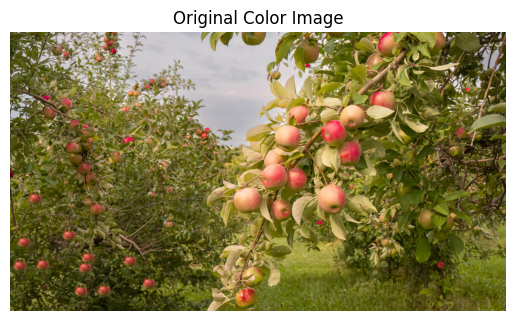

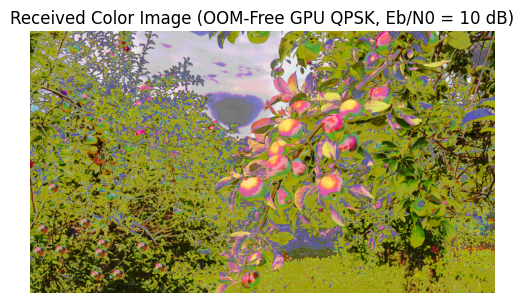

In [1]:
import cv2
import cupy as cp
import matplotlib.pyplot as plt

# -----------------------------
# 1. READ IMAGE (CPU → GPU)
# -----------------------------
img = cv2.imread("/kaggle/input/images1/AppleHarvest-UHD.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

rows, cols, ch = img.shape

plt.imshow(img)
plt.title("Original Color Image")
plt.axis("off")

# Flatten image → GPU
img_gpu = cp.asarray(img.flatten())

# -----------------------------
# 2. IMAGE → BITSTREAM (GPU)
# -----------------------------
bits = cp.unpackbits(img_gpu)

# -----------------------------
# 3. QPSK MODULATION (GPU)
# -----------------------------
bit_pairs = bits.reshape(-1, 2)

indices = bit_pairs[:, 0] * 2 + bit_pairs[:, 1]   # 0..3

mapping = cp.array([
    (1+1j)/cp.sqrt(2),
    (-1+1j)/cp.sqrt(2),
    (1-1j)/cp.sqrt(2),
    (-1-1j)/cp.sqrt(2)
], dtype=cp.complex64)

symbols = mapping[indices]

# -----------------------------
# 4. AWGN NOISE (GPU)
# -----------------------------
EbN0_dB = 10
EbN0 = 10 ** (EbN0_dB / 10)

Es = cp.mean(cp.abs(symbols)**2)
N0 = Es / EbN0

noise = cp.sqrt(N0/2) * (cp.random.randn(len(symbols)) +
                         1j * cp.random.randn(len(symbols)))

rx_symbols = symbols + noise

# -----------------------------
# 5. QPSK DEMODULATION (OOM-FREE)
# -----------------------------
real = cp.real(rx_symbols)
imag = cp.imag(rx_symbols)

# Quadrant decision
b0 = (real < 0).astype(cp.uint8)  # MSB
b1 = (imag < 0).astype(cp.uint8)  # LSB

rx_bits = cp.column_stack((b0, b1)).reshape(-1)

# -----------------------------
# 6. BITSTREAM → COLOR IMAGE
# -----------------------------
rx_bytes = cp.packbits(rx_bits).get()
rx_img = rx_bytes.reshape(rows, cols, ch).astype('uint8')

plt.figure(figsize=(6,6))
plt.imshow(rx_img)
plt.title(f"Received Color Image (OOM-Free GPU QPSK, Eb/N0 = {EbN0_dB} dB)")
plt.axis("off")
plt.show()
